# Predictions Comparisons
- IPCA20
- IPCA5
- Monte Carlo Simulations (benchmark)
- SPX price inferred with parity
- SPX real price movements vs inferred with parity

All predictions were done under put-call parity to ensure an even comparison in terms of framework

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Prediction Results - Test Set

In [25]:
# IPCA Calls and IPCA Puts prediction results - Test Set
IPCA_calls20 = pd.read_csv('IPCA_Calls_Predictions_Test20.csv').drop('Unnamed: 0', axis=1)
IPCA_puts20 = pd.read_csv('IPCA_Puts_Predictions_Test20.csv').drop('Unnamed: 0', axis=1)
IPCA_calls20.columns = [str(col) + '_calls20' for col in IPCA_calls20.columns]
IPCA_puts20.columns = [str(col) + '_puts20' for col in IPCA_puts20.columns]

IPCA_calls5 = pd.read_csv('IPCA_Calls_Predictions_Test5.csv').drop('Unnamed: 0', axis=1)
IPCA_puts5 = pd.read_csv('IPCA_Puts_Predictions_Test5.csv').drop('Unnamed: 0', axis=1)
IPCA_calls5.columns = [str(col) + '_calls5' for col in IPCA_calls5.columns]
IPCA_puts5.columns = [str(col) + '_puts5' for col in IPCA_puts5.columns]

# Main sets
SPX_calls = pd.read_csv('Test_Calls20.csv').drop('call_payoff', axis=1)
SPX_puts = pd.read_csv('Test_Puts20.csv').drop('put_payoff', axis=1)
SPX_calls = SPX_calls.drop(['month', 'unique_id'], axis=1)
SPX_puts = SPX_puts.drop(['month', 'unique_id'], axis=1)

# Merging and cleaning
calls = pd.concat([IPCA_calls20, IPCA_calls5,SPX_calls], axis=1)
puts = pd.concat([IPCA_puts20, IPCA_puts5, SPX_puts], axis=1)
data = pd.concat([calls, puts], axis=1)
data = data.drop(['True_calls5', 'True_puts5'], axis=1)
data = data.rename(columns={'True_calls20': 'True_calls', 'True_puts20': 'True_puts'})
data = data.loc[:,~data.columns.duplicated()]
data = data[['date', 'spot_price', 'strike_price', 'time_to_maturity_OPT', 'risk_free', 'impl_volatility', 'True_calls', 'Predicted_calls20', 'Predicted_calls5', 'True_puts', 'Predicted_puts20', 'Predicted_puts5']]
data = data.dropna()

In [26]:
# Monte Carlo results - Test Set
MCtest = pd.read_csv('MC Test Results.csv')

- S_ipca20 = K_real + IPCA Call20 - IPCA Puts20 
- S_ipca5 = K_real + IPCA Call5 - IPCA Puts5
- S_MC = K_real + MC Call - MC Puts
- S_real = K_real + True Call - True Puts

In [27]:
# Inferred index price
data['S_real'] = data['strike_price'] + data['True_calls'] - data['True_puts']
data['S_ipca20'] = data['strike_price'] + data['Predicted_calls20'] - data['Predicted_puts20']
data['S_ipca5'] = data['strike_price'] + data['Predicted_calls5'] - data['Predicted_puts5']
data['S_mc'] = data['strike_price'] + MCtest['Monte_Carlo_Call'] - MCtest['Monte_Carlo_Put']

# Daily returns
data['S_real_returns'] = data['S_real'].pct_change()
data['S_ipca20_returns'] = data['S_ipca20'].pct_change()
data['S_ipca5_returns'] = data['S_ipca5'].pct_change()
data['S_mc_returns'] = data['S_mc'].pct_change()
data['spot_price_returns'] = data['spot_price'].pct_change() 

# Date grouping and mean
data['date'] = pd.to_datetime(data['date'])
daily_data = data.groupby('date').mean()
daily_data['S_real_returns'] = daily_data['S_real'].pct_change()
daily_data['S_ipca20_returns'] = daily_data['S_ipca20'].pct_change()
daily_data['S_ipca5_returns'] = daily_data['S_ipca5'].pct_change()
daily_data['S_mc_returns'] = daily_data['S_mc'].pct_change()
daily_data['spot_price_returns'] = daily_data['spot_price'].pct_change() # Real index returns (not inferred with parity)
daily_data = daily_data.reset_index()
print(daily_data[['date', 'S_real_returns', 'S_ipca20_returns', 'S_ipca5_returns', 'S_mc_returns', 'spot_price_returns']].head())

        date  S_real_returns  S_ipca20_returns  S_ipca5_returns  S_mc_returns  \
0 2017-01-03             NaN               NaN              NaN           NaN   
1 2017-01-04        0.000949          0.000583         0.002402      0.008975   
2 2017-01-05       -0.001520         -0.000685         0.001726     -0.000648   
3 2017-01-06        0.005560          0.006600         0.012276      0.002610   
4 2017-01-09       -0.005226         -0.004580        -0.005799     -0.006109   

   spot_price_returns  
0                 NaN  
1            0.005722  
2           -0.000771  
3            0.003517  
4           -0.003549  


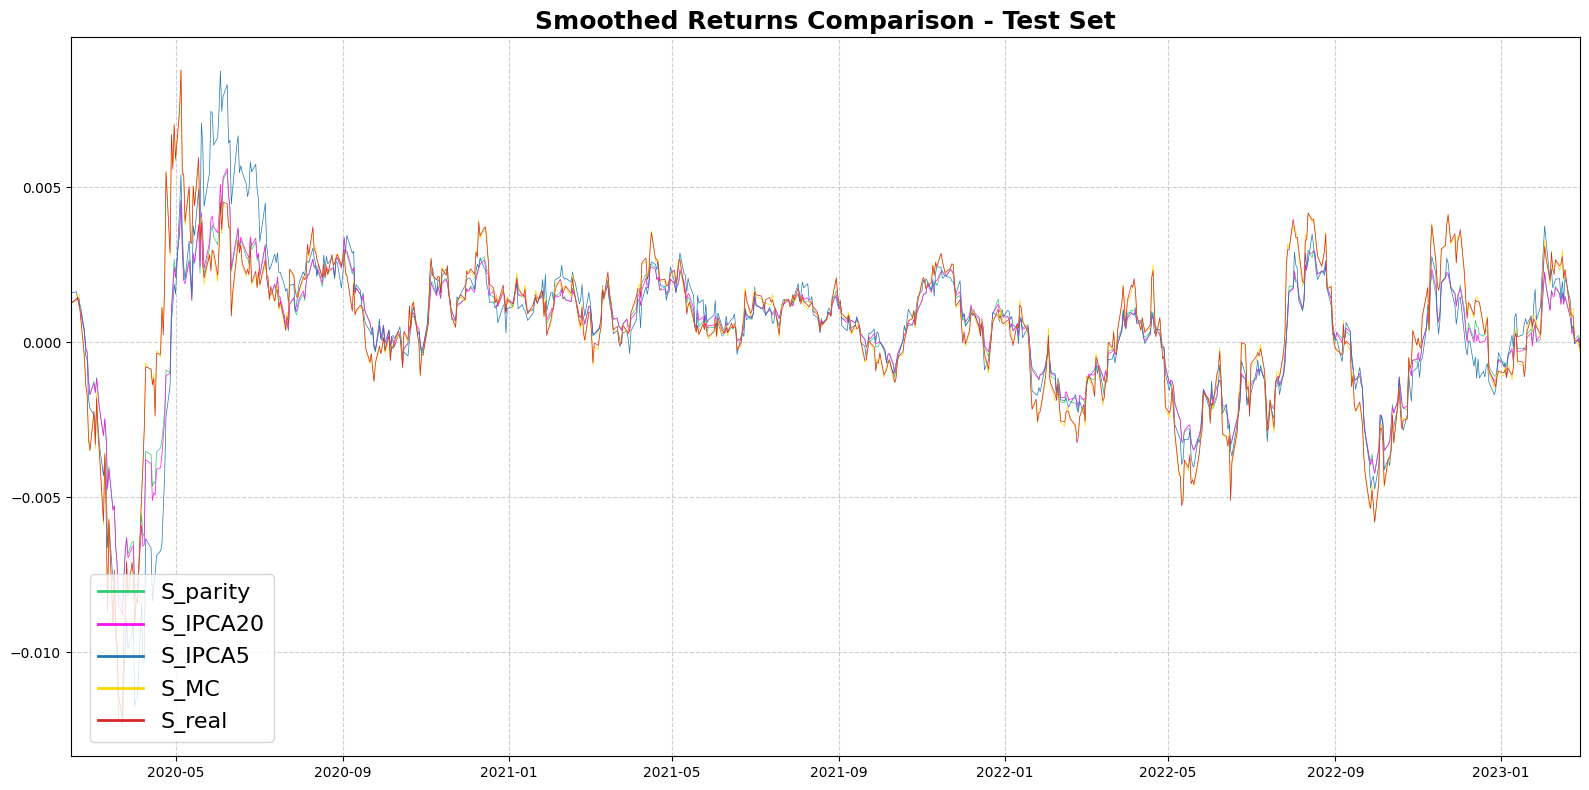

In [37]:
# Applying a rolling mean to smooth the data (30-day moving average)
daily_data['S_real_smooth'] = daily_data['S_real_returns'].rolling(window=30).mean()
daily_data['S_ipca20_smooth'] = daily_data['S_ipca20_returns'].rolling(window=30).mean()
daily_data['S_ipca5_smooth'] = daily_data['S_ipca5_returns'].rolling(window=30).mean()
daily_data['S_mc_smooth'] = daily_data['S_mc_returns'].rolling(window=30).mean()
daily_data['spot_price_smooth'] = daily_data['spot_price_returns'].rolling(window=30).mean()

# Removing initial rows with NaN values after smoothing
start_date = daily_data['date'].loc[daily_data[['S_real_smooth', 'S_ipca20_smooth', 'S_ipca5_smooth', 'S_mc_smooth', 'spot_price_smooth']].first_valid_index()]

# Comparing the smoothed returns
plt.figure(figsize=(16, 8))
plt.plot(daily_data['date'], daily_data['S_real_smooth'], label='S_parity', linewidth=0.5, color='#2ecc71')
plt.plot(daily_data['date'], daily_data['S_ipca20_smooth'], label='S_IPCA20', linewidth=0.5, color='#FF10F0')
plt.plot(daily_data['date'], daily_data['S_ipca5_smooth'], label='S_IPCA5', linewidth=0.5, color='#1f77b4')
plt.plot(daily_data['date'], daily_data['S_mc_smooth'], label='S_MC', linewidth=0.5, color='gold')
plt.plot(daily_data['date'], daily_data['spot_price_smooth'], label='S_real', linewidth=0.5, color='#d62728')

custom_lines = [
    Line2D([0], [0], color='#2ecc71', lw=2),
    Line2D([0], [0], color='#FF10F0', lw=2),
    Line2D([0], [0], color='#1f77b4', lw=2),
    Line2D([0], [0], color='gold', lw=2),
    Line2D([0], [0], color='#d62728', lw=2)
]
plt.title('Smoothed Returns Comparison - Test Set', fontsize=18, fontweight='bold')
plt.legend(custom_lines, ['S_parity', 'S_IPCA20', 'S_IPCA5', 'S_MC', 'S_real'], fontsize=16, loc='lower left', bbox_to_anchor=(0.005, 0.005))
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([start_date, daily_data['date'].iloc[-1]])
plt.tight_layout()
plt.show()

# Prediction Results - Covid Set

In [31]:
# IPCA Calls and IPCA Puts prediction results - Covid Set
IPCA_calls20 = pd.read_csv('IPCA_Calls_Predictions_Covid20.csv').drop('Unnamed: 0', axis=1)
IPCA_puts20 = pd.read_csv('IPCA_Puts_Predictions_Covid20.csv').drop('Unnamed: 0', axis=1)
IPCA_calls20.columns = [str(col) + '_calls20' for col in IPCA_calls20.columns]
IPCA_puts20.columns = [str(col) + '_puts20' for col in IPCA_puts20.columns]

IPCA_calls5 = pd.read_csv('IPCA_Calls_Predictions_Covid5.csv').drop('Unnamed: 0', axis=1)
IPCA_puts5 = pd.read_csv('IPCA_Puts_Predictions_Covid5.csv').drop('Unnamed: 0', axis=1)
IPCA_calls5.columns = [str(col) + '_calls5' for col in IPCA_calls5.columns]
IPCA_puts5.columns = [str(col) + '_puts5' for col in IPCA_puts5.columns]

# Main sets
SPX_calls = pd.read_csv('Covid_Calls20.csv').drop('call_payoff', axis=1)
SPX_puts = pd.read_csv('Covid_Puts20.csv').drop('put_payoff', axis=1)
SPX_calls = SPX_calls.drop(['month', 'unique_id'], axis=1)
SPX_puts = SPX_puts.drop(['month', 'unique_id'], axis=1)

# Merging and cleaning
calls = pd.concat([IPCA_calls20, IPCA_calls5,SPX_calls], axis=1)
puts = pd.concat([IPCA_puts20, IPCA_puts5, SPX_puts], axis=1)
data = pd.concat([calls, puts], axis=1)
data = data.drop(['True_calls5', 'True_puts5'], axis=1)
data = data.rename(columns={'True_calls20': 'True_calls', 'True_puts20': 'True_puts'})
data = data.loc[:,~data.columns.duplicated()]
data = data[['date', 'spot_price', 'strike_price', 'time_to_maturity_OPT', 'risk_free', 'impl_volatility', 'True_calls', 'Predicted_calls20', 'Predicted_calls5', 'True_puts', 'Predicted_puts20', 'Predicted_puts5']]
data = data.dropna()

In [32]:
# Monte Carlo results - Covid Set
MCcovid = pd.read_csv('MC COVID Results.csv')

- S_ipca20 = K_real + IPCA Call20 - IPCA Puts20 
- S_ipca5 = K_real + IPCA Call5 - IPCA Puts5
- S_MC = K_real + MC Call - MC Puts
- S_real = K_real + True Call - True Puts

In [33]:
# Inferred index price
data['S_real'] = data['strike_price'] + data['True_calls'] - data['True_puts']
data['S_ipca20'] = data['strike_price'] + data['Predicted_calls20'] - data['Predicted_puts20']
data['S_ipca5'] = data['strike_price'] + data['Predicted_calls5'] - data['Predicted_puts5']
data['S_mc'] = data['strike_price'] + MCcovid['Monte_Carlo_Call'] - MCcovid['Monte_Carlo_Put']

# Daily returns
data['S_real_returns'] = data['S_real'].pct_change()
data['S_ipca20_returns'] = data['S_ipca20'].pct_change()
data['S_ipca5_returns'] = data['S_ipca5'].pct_change()
data['S_mc_returns'] = data['S_mc'].pct_change()
data['spot_price_returns'] = data['spot_price'].pct_change() 

# Date grouping and mean
data['date'] = pd.to_datetime(data['date'])
daily_data = data.groupby('date').mean()
daily_data['S_real_returns'] = daily_data['S_real'].pct_change()
daily_data['S_ipca20_returns'] = daily_data['S_ipca20'].pct_change()
daily_data['S_ipca5_returns'] = daily_data['S_ipca5'].pct_change()
daily_data['S_mc_returns'] = daily_data['S_mc'].pct_change()
daily_data['spot_price_returns'] = daily_data['spot_price'].pct_change() # Real index returns (not inferred with parity)
daily_data = daily_data.reset_index()
print(daily_data[['date', 'S_real_returns', 'S_ipca20_returns', 'S_ipca5_returns', 'S_mc_returns', 'spot_price_returns']].head())

        date  S_real_returns  S_ipca20_returns  S_ipca5_returns  S_mc_returns  \
0 2020-01-02             NaN               NaN              NaN           NaN   
1 2020-01-03       -0.003254         -0.003041        -0.004455     -0.009491   
2 2020-01-06       -0.000487          0.001506         0.010764      0.001766   
3 2020-01-07        0.003306          0.002717         0.000165     -0.002503   
4 2020-01-08        0.000987         -0.000766        -0.003938      0.008175   

   spot_price_returns  
0                 NaN  
1           -0.007060  
2            0.003533  
3           -0.002803  
4            0.004902  


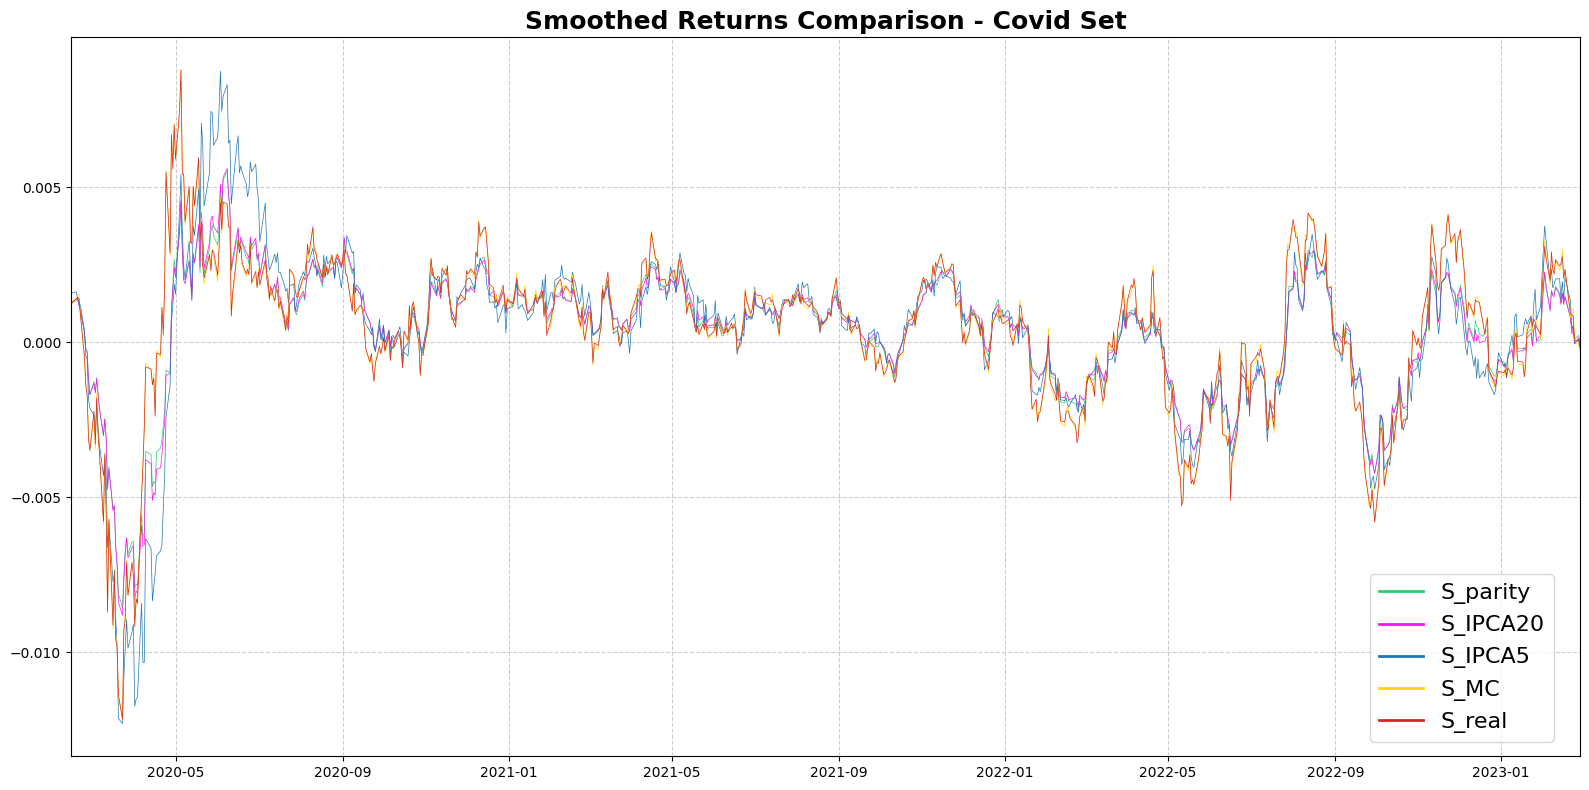

In [36]:
# Applying a rolling mean to smooth the data (30-day moving average)
daily_data['S_real_smooth'] = daily_data['S_real_returns'].rolling(window=30).mean()
daily_data['S_ipca20_smooth'] = daily_data['S_ipca20_returns'].rolling(window=30).mean()
daily_data['S_ipca5_smooth'] = daily_data['S_ipca5_returns'].rolling(window=30).mean()
daily_data['S_mc_smooth'] = daily_data['S_mc_returns'].rolling(window=30).mean()
daily_data['spot_price_smooth'] = daily_data['spot_price_returns'].rolling(window=30).mean()

# Removing initial rows with NaN values after smoothing
start_date = daily_data['date'].loc[daily_data[['S_real_smooth', 'S_ipca20_smooth', 'S_ipca5_smooth', 'S_mc_smooth', 'spot_price_smooth']].first_valid_index()]

# Comparing the smoothed returns
plt.figure(figsize=(16, 8))
plt.plot(daily_data['date'], daily_data['S_real_smooth'], label='S_parity', linewidth=0.5, color='#2ecc71')
plt.plot(daily_data['date'], daily_data['S_ipca20_smooth'], label='S_IPCA20', linewidth=0.5, color='#FF10F0')
plt.plot(daily_data['date'], daily_data['S_ipca5_smooth'], label='S_IPCA5', linewidth=0.5, color='#1f77b4')
plt.plot(daily_data['date'], daily_data['S_mc_smooth'], label='S_MC', linewidth=0.5, color='gold')
plt.plot(daily_data['date'], daily_data['spot_price_smooth'], label='S_real', linewidth=0.5, color='#d62728')

custom_lines = [
    Line2D([0], [0], color='#2ecc71', lw=2),
    Line2D([0], [0], color='#FF10F0', lw=2),
    Line2D([0], [0], color='#1f77b4', lw=2),
    Line2D([0], [0], color='gold', lw=2),
    Line2D([0], [0], color='#d62728', lw=2)
]
plt.title('Smoothed Returns Comparison - Covid Set', fontsize=18, fontweight='bold')
plt.legend(custom_lines, ['S_parity', 'S_IPCA20', 'S_IPCA5', 'S_MC', 'S_real'], fontsize=16, loc='lower right', bbox_to_anchor=(0.99, 0.005))
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([start_date, daily_data['date'].iloc[-1]])
plt.tight_layout()
plt.show()